In [2]:
!pip install carbontracker
!pip install codecarbon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 38.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.4/63.4 kB 3.9 MB/s eta 0:00:00
  Created wheel for reportlab: filename=reportlab-3.6.13-cp312-cp312-linux_x86_64.whl size=2237985 sha256=5da2c59970e860dd0eb43d5086b5294c8cc1f976c7ec4b1d8795d66a80116a24
  Stored in directory: /root/.cache/pip/wheels/48/67/58/d54706b91458551310cfa11bd10777cb55438c6f33bf3a5292
Successfully built reportlab
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.0/278.0 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import matplotlib

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
colors = ["#EF476F",  "#06D6A0", "#FFD166", "#073B4C"]


plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 'medium',
})

import wandb
from wandb.integration.keras import WandbCallback


from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [45]:
data_dir = 'data/DailyDelhiClimateTrain.csv'
df = pd.read_csv(data_dir)

In [3]:
# Initialize a W&B run and set hyperparameters
wandb.login(key="d0443b4249d89fb1ed2dde3aa1dedea814f47c61")
wandb.init(
    project="MLOPS-Hackathon",   # Name of your project
    entity="emiliewedenborg-technical-university-of-denmark",  # Replace with your W&B entity
    name="temperature-forecasting-cnn-smaller",  # Name of the run

    config={
        "epochs": 100,
        "batch_size": 32,
        "learning_rate": 0.001,
        "optimizer": "adam"
    }
)

config = wandb.config


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ask-e-oren (emiliewedenborg-technical-university-of-denmark) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


# Do actual predictions!

# Predict more than just the temp (multivariate predictions)

In [52]:
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df.set_index('date', inplace= True)

n_cols = 4
cols = list(df.loc[:, ['meantemp', 'humidity', 'wind_speed', 'meanpressure']])
dataset = df[cols]
dataset = pd.DataFrame(dataset)
data = dataset.values

data.shape

(1462, 4)

In [53]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data))

In [54]:
train_size = int(len(data) * 0.75)
test_size = len(data) - train_size
print("Train Size :",train_size,"Test Size :",test_size)

Train Size : 1096 Test Size : 366


In [55]:
train_data = scaled_data[0:train_size, :]
train_data.shape

(1096, 4)

In [61]:
# Creating a Training set with 60 time-steps
x_train = []
y_train = []
time_steps = 30
n_cols = 4

for i in range(time_steps, len(train_data)):
    x_train.append(train_data[i-time_steps:i, :n_cols])
    y_train.append(train_data[i, :n_cols])

In [62]:
# Convert to numpy array
x_train, y_train = np.array(x_train), np.array(y_train)

In [63]:
# Reshaping the input to (n_samples, time_steps, n_feature)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], n_cols))
x_train.shape , y_train.shape

((1066, 30, 4), (1066, 4))

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

model2 = Sequential([
    Conv1D(filters=16, kernel_size=3, activation="relu", input_shape=(x_train.shape[1], n_cols)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation="relu"),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(32, activation="relu"),
    Dropout(0.2),
    Dense(16, activation="relu"),
    Dense(n_cols)
])

model2.compile(optimizer="adam", loss="mse", metrics=["mean_absolute_error"])


In [65]:
history2 = model2.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=32,
    callbacks=[WandbCallback(save_graph=False)]
)


Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2088 - mean_absolute_error: 0.3848
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0778 - mean_absolute_error: 0.2156
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0427 - mean_absolute_error: 0.1617
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0331 - mean_absolute_error: 0.1416
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0282 - mean_absolute_error: 0.1300
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0258 - mean_absolute_error: 0.1218
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0256 - mean_absolute_error: 0.1229
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0253 - mean_absolute_error: 0.1231
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0222 - mean_absolute_error: 0.1161
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0203 - mean_absolute_error: 0.1109
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━

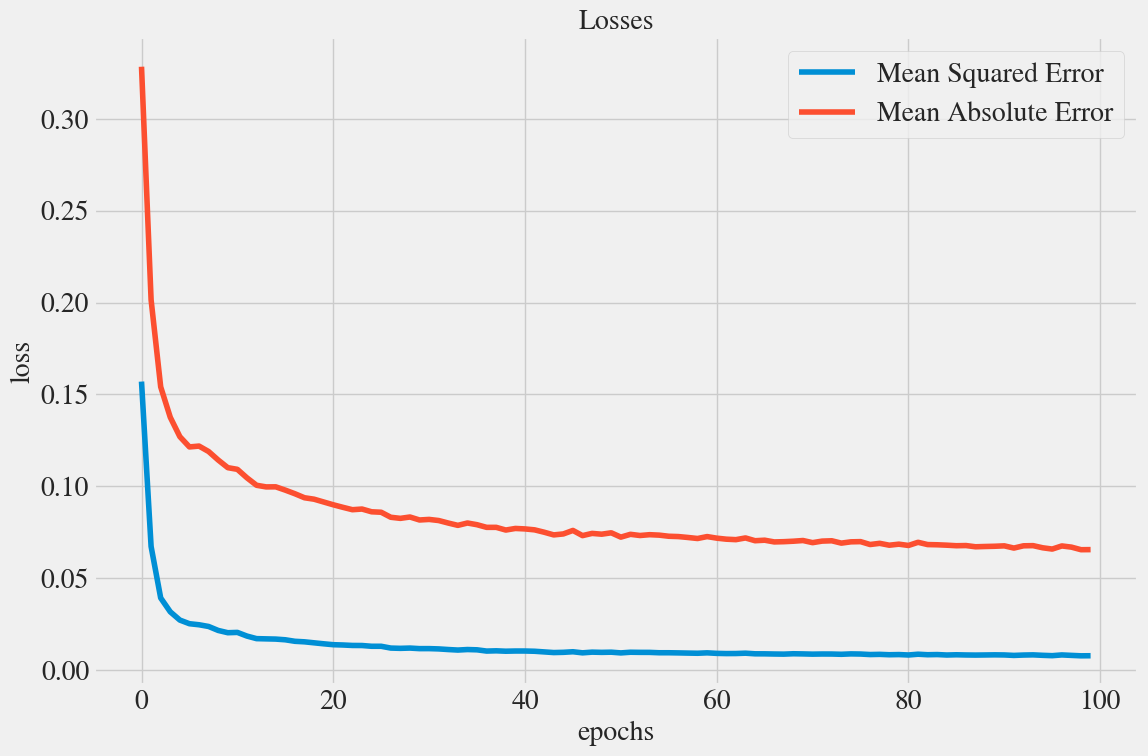

In [66]:
plt.figure(figsize=(12, 8))
plt.plot(history2.history["loss"])
plt.plot(history2.history["mean_absolute_error"])
plt.legend(['Mean Squared Error','Mean Absolute Error'])
plt.title("Losses")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [67]:
# Creating a testing set with 30 time-steps and 1 output
time_steps = 30
test_data = scaled_data[train_size - time_steps:, :]

x_test = []
y_test = []
n_cols = 4

for i in range(time_steps, len(test_data)):
    x_test.append(test_data[i-time_steps:i, 0:n_cols])
    y_test.append(test_data[i, 0:n_cols])
x_test, y_test = np.array(x_test), np.array(y_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], n_cols))

In [68]:
x_test.shape , y_test.shape

((366, 30, 4), (366, 4))

In [86]:
# Get Prediction
predictions = model2.predict(x_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [87]:
#inverse y_test scaling
y_test = scaler.inverse_transform(y_test)

In [88]:
RMSE = np.sqrt(np.mean( y_test - predictions )**2).round(2)
RMSE

np.float64(9792.87)

In [72]:
from datetime import timedelta

In [74]:
def insert_end(Xin, new_input):
    timestep = 30
    for i in range(timestep - 1):
        Xin[:, i, :] = Xin[:, i+1, :]
    Xin[:, timestep - 1, :] = new_input
    return Xin

In [75]:
future = 30
forcast = []
Xin = x_test[-1 :, :, :]
time = []
for i in range(0, future):
    out = model2.predict(Xin, batch_size=5)
    forcast.append(out[0])
    print(forcast)
    Xin = insert_end(Xin, out[0, 0])
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
[array([0.35740668, 0.63861215, 0.10886344, 0.7260467 ], dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
[array([0.35740668, 0.63861215, 0.10886344, 0.7260467 ], dtype=float32), array([0.3959482 , 0.6103772 , 0.12205041, 0.70955443], dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
[array([0.35740668, 0.63861215, 0.10886344, 0.7260467 ], dtype=float32), array([0.3959482 , 0.6103772 , 0.12205041, 0.70955443], dtype=float32), array([0.3794309 , 0.62210834, 0.12146062, 0.7211486 ], dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
[array([0.35740668, 0.63861215, 0.10886344, 0.7260467 ], dtype=float32), array([0.3959482 , 0.6103772 , 0.12205041, 0.70955443], dtype=float32), array([0.3794309 , 0.62210834, 0.12146062, 0.7211486 ], dtype=float32), array([0.4491074 , 0.561142  , 0.15155348, 0.6802658 ], dtype=float32)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
[array([0.35740668, 0.63861215, 0.10886344, 0.7260467 ], dtype=float32), array([0.395

In [76]:
forcasted_output = np.asanyarray(forcast)
forcasted_output = scaler.inverse_transform(forcasted_output)

In [77]:
forcasted_output = pd.DataFrame(forcasted_output)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", 'meantemp', 'humidity', 'wind_speed', 'meanpressure'
df_result.head()

,Date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,17.692305,68.714134,4.596214,1014.336182
1,2017-01-02,18.953161,66.269798,5.152968,1013.814636
2,2017-01-03,18.412811,67.285378,5.128067,1014.181274
3,2017-01-04,20.692228,62.007435,6.398588,1012.888367
4,2017-01-05,21.155033,59.713970,6.483419,1012.148865


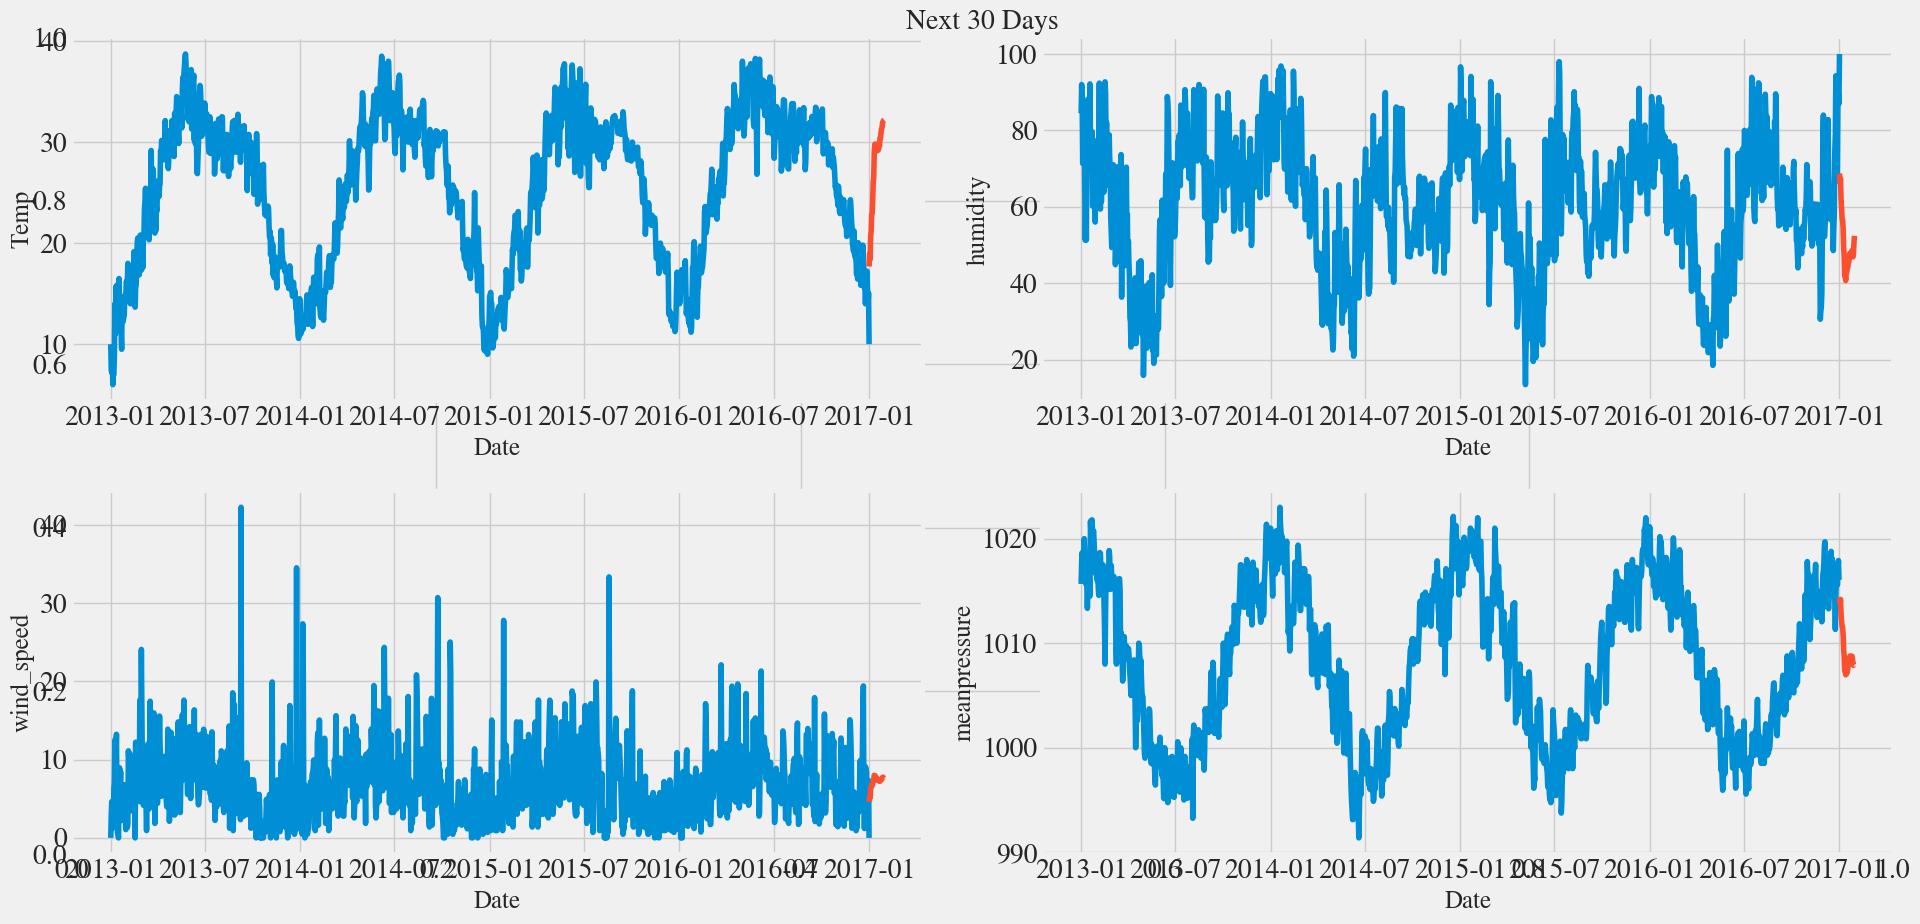

In [78]:
plt.figure(figsize=(20, 10))
plt.title('Next 30 Days')

plt.subplot(2, 2, 1)
plt.plot(df['meantemp'])
plt.plot(df_result.set_index('Date')[['meantemp']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Temp' ,fontsize=18)

plt.subplot(2, 2, 2)
plt.plot(df['humidity'])
plt.plot(df_result.set_index('Date')[['humidity']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('humidity' ,fontsize=18)

plt.subplot(2, 2, 3)
plt.plot(df['wind_speed'])
plt.plot(df_result.set_index('Date')[['wind_speed']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('wind_speed' ,fontsize=18)

plt.subplot(2, 2, 4)
plt.plot(df['meanpressure'])
plt.plot(df_result.set_index('Date')[['meanpressure']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('meanpressure' ,fontsize=18)

plt.tight_layout()
plt.show()

In [79]:
model2.save("temperature_forecasting_cnn_small.keras")

In [80]:
import pathlib

converter = tf.lite.TFLiteConverter.from_keras_model(model2)


converter.optimizations = [tf.lite.Optimize.DEFAULT]    # Uncomment this line for Model 2 and Model 3

#def representative_data_gen():                          # Uncomment the following 5 lines for Model 3
#    for input_value, _ in test_batches.take(200):
#        yield [input_value]
#converter.representative_dataset = representative_data_gen
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

tflite_model = converter.convert()
tflite_models_dir = pathlib.Path("")

tflite_model_file = tflite_models_dir/'cnn_small.tflite'     # Change the filename here for Model2 and Model3!
x = tflite_model_file.write_bytes(tflite_model)



Saved artifact at '/tmp/tmpfl_rrerl'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 4), dtype=tf.float32, name='keras_tensor_20')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  135592164219728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135592164225296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135592164226256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135592164225488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135592164226640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135592164226448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135592164227024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135592164226832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135592164227408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135592164227600: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [81]:

print(x)

17440


In [42]:
!pip install ai_edge_litert

In [90]:
#@title Run this cell each time to test your model's accuracy (make sure to change the filename)
from tqdm import tqdm
from ai_edge_litert.interpreter import Interpreter

# Load TFLite model and allocate tensors.
tflite_model_file = '/content/cnn_small.tflite'                 # Change the filename here for Model 2 and 3
interpreter = Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [91]:
# Iterate over the test data and run inference
future = 30
Xin2 = x_test[-1 :, :, :]
time = []
test_predictions = []
for i in tqdm(range(0, future)):
    input_data = Xin2.astype('float32')  # Ensure input data is float32
    interpreter.set_tensor(input_index, input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_index)
    test_predictions.append(output_data[0])
    time.append(pd.to_datetime(df.index[-1]) + timedelta(days=i))

test_predictions = np.array(test_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

100%|██████████| 30/30 [00:00<00:00, 8623.16it/s]


In [92]:
forcasted_output = pd.DataFrame(test_predictions)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_output], axis=1)
df_result.columns = "Date", 'meantemp', 'humidity', 'wind_speed', 'meanpressure'
df_result.head()

,Date,meantemp,humidity,wind_speed,meanpressure
0,2017-01-01,32.216766,52.774593,7.563022,1007.970154
1,2017-01-02,32.216766,52.774593,7.563022,1007.970154
2,2017-01-03,32.216766,52.774593,7.563022,1007.970154
3,2017-01-04,32.216766,52.774593,7.563022,1007.970154
4,2017-01-05,32.216766,52.774593,7.563022,1007.970154


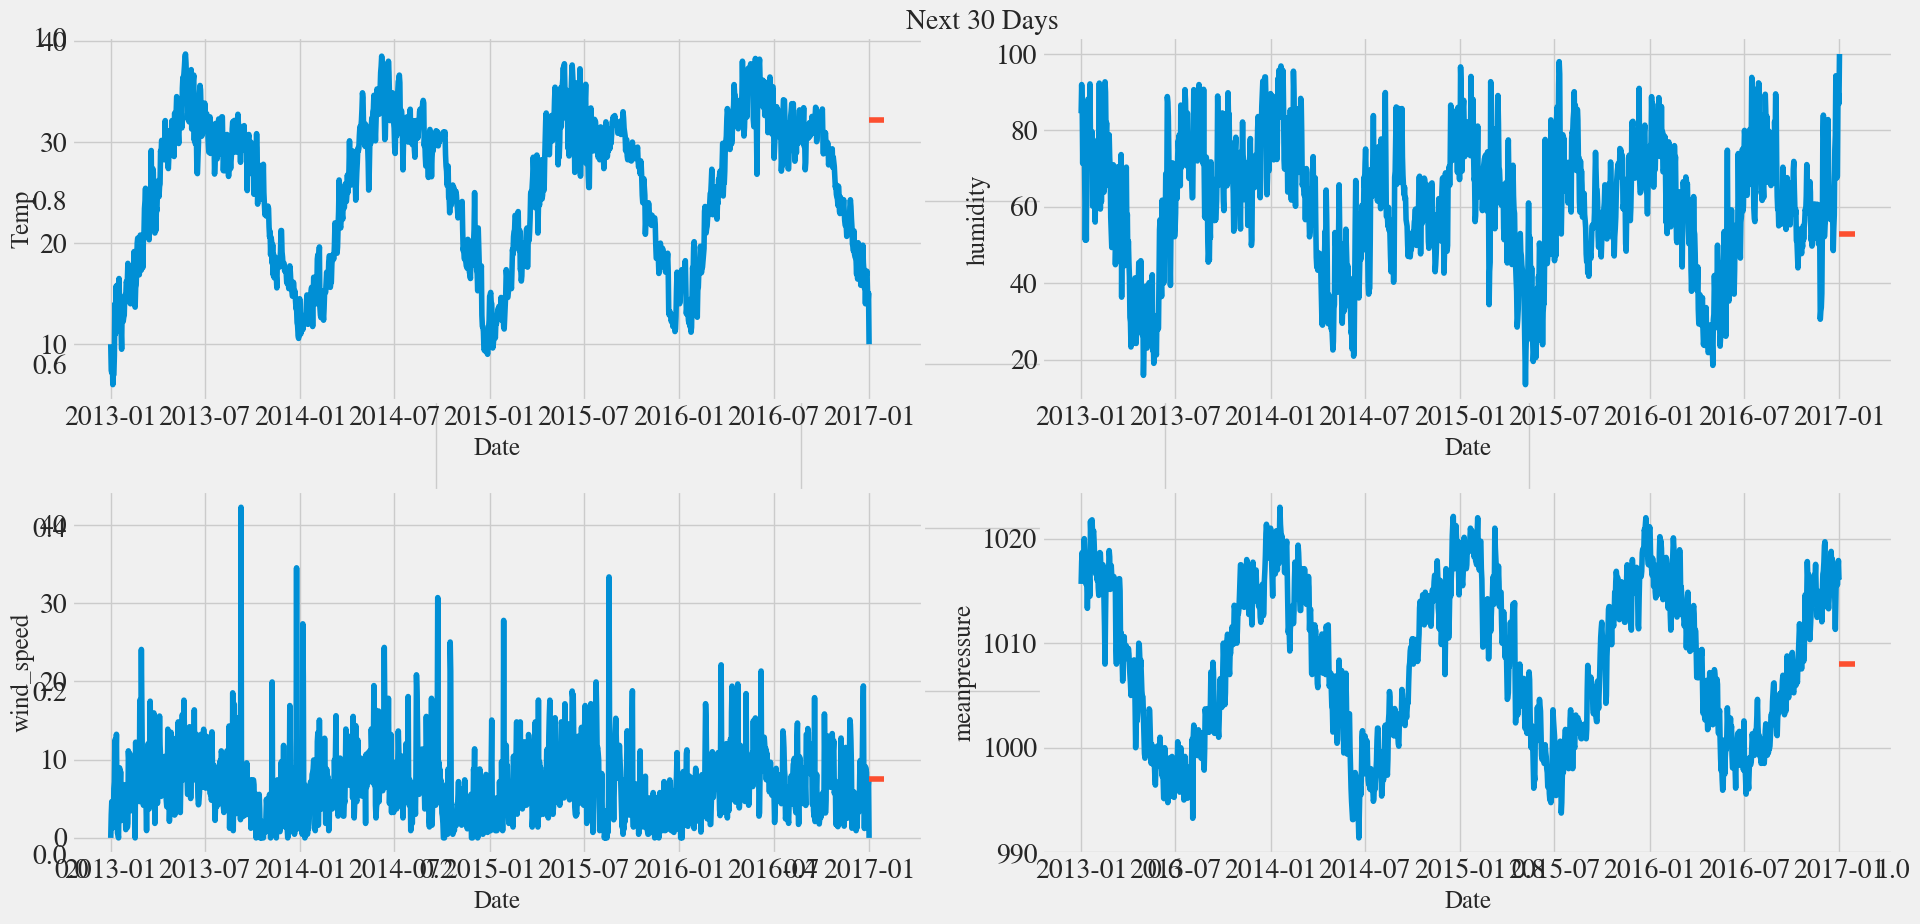

In [93]:
plt.figure(figsize=(20, 10))
plt.title('Next 30 Days')

plt.subplot(2, 2, 1)
plt.plot(df['meantemp'])
plt.plot(df_result.set_index('Date')[['meantemp']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Temp' ,fontsize=18)

plt.subplot(2, 2, 2)
plt.plot(df['humidity'])
plt.plot(df_result.set_index('Date')[['humidity']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('humidity' ,fontsize=18)

plt.subplot(2, 2, 3)
plt.plot(df['wind_speed'])
plt.plot(df_result.set_index('Date')[['wind_speed']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('wind_speed' ,fontsize=18)

plt.subplot(2, 2, 4)
plt.plot(df['meanpressure'])
plt.plot(df_result.set_index('Date')[['meanpressure']])
plt.xlabel('Date', fontsize=18)
plt.ylabel('meanpressure' ,fontsize=18)

plt.tight_layout()
plt.show()